Основные шаги:

*    цели и задачи проекта, описание исходных и обработанных данных и признаков.
*    первичный анализ признаков
*    первичный визуальный анализ признаков
*    если пришли к каким-то "инсайтам", обнаружили закономерности – изложите
*    описание предобработки данных
*    если создаются признаки, то описание этого процесса
*    кросс-валидация, построение кривых валидации и обучения
*    оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться
*    выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

Цели и задачи проекта, описание исходных и обработанных данных и признаков
---
**Цели и задачи**:

Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.

**Описание исходных данных**:
*    Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
*    Признаки time_j – время посещения сайтов site_j
*    Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import itertools
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
PATH_TO_DATA = 'data/'
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]

#### Загрузка данных

In [80]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates = times)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates = times)
y = train_df['target'].values

Посмотрим на распределение сессий Элис и других пользователей.

In [4]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [5]:
train_test_df = pd.concat([train_df.drop('target', axis=1), test_df])

In [6]:
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 82797
Data columns (total 20 columns):
site1     336358 non-null int64
time1     336358 non-null datetime64[ns]
site2     331406 non-null float64
time2     331406 non-null datetime64[ns]
site3     326994 non-null float64
time3     326994 non-null datetime64[ns]
site4     323503 non-null float64
time4     323503 non-null datetime64[ns]
site5     320170 non-null float64
time5     320170 non-null datetime64[ns]
site6     317061 non-null float64
time6     317061 non-null datetime64[ns]
site7     314137 non-null float64
time7     314137 non-null datetime64[ns]
site8     311375 non-null float64
time8     311375 non-null datetime64[ns]
site9     308568 non-null float64
time9     308568 non-null datetime64[ns]
site10    305858 non-null float64
time10    305858 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 53.9 MB


#### Создание новых признаков

Время сессии

In [7]:
train_test_df['session_lenght'] = (train_test_df[times].max(axis=1) - train_test_df[times].min(axis=1)).apply(lambda td: td.total_seconds())

In [8]:
train_test_df['lenght'] = ['short' if l <=40 else 'long' for l in train_test_df['session_lenght']]

Час начала сессии

In [9]:
train_test_df['start_hour'] = train_test_df['time1'].apply(lambda time: time.hour)

Дата начала сессии

In [10]:
train_test_df['start_dt'] = train_test_df['time1'].dt.strftime('%Y%m%d')
train_test_df['start_yyyymm'] = train_test_df['time1'].dt.strftime('%Y%m')
train_test_df['start_mm'] = train_test_df['time1'].dt.month
train_test_df['start_dd'] = train_test_df['time1'].dt.day
train_test_df['start_yyyy'] = train_test_df['time1'].dt.year

Время суток начала сессии

In [11]:
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
train_test_df['start_dt_part'] = pd.cut(train_test_df['start_hour'], bins=b, labels=l)

День начала сессии, выходной

In [12]:
train_test_df['holiday'] = [1 if (d==5) or (d==6) else 0 for d in train_test_df['time1'].dt.weekday]
train_test_df['day_of_week'] = train_test_df['time1'].dt.weekday

Число уникальных сайтов в сессии

In [13]:
train_test_df['n_sites'] = train_test_df[sites].nunique(axis=1)

Время проведенное на сайтах

In [14]:
diffs = ['diff%d' % i for i in range(1, 10)] # Названия будущих колонок датафрейма с временами
diff = train_test_df[times].diff(axis='columns') # Разница во времении между посещениями сайтов
diff = diff.iloc[:, 1:] 
diff.columns = diffs
diff = diff.applymap(lambda x: int(x.total_seconds()))
diff = diff.applymap(lambda x: 0 if x > 10000 else x)

In [15]:
# Собираю все в одну кучу
train_test_df = pd.concat([train_test_df.drop(times, axis=1), diff], axis=1)
train_test_df[sites] = train_test_df[sites].fillna(0).astype(int)
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 82797
Data columns (total 31 columns):
site1             336358 non-null int64
site2             336358 non-null int64
site3             336358 non-null int64
site4             336358 non-null int64
site5             336358 non-null int64
site6             336358 non-null int64
site7             336358 non-null int64
site8             336358 non-null int64
site9             336358 non-null int64
site10            336358 non-null int64
session_lenght    336358 non-null float64
lenght            336358 non-null object
start_hour        336358 non-null int64
start_dt          336358 non-null object
start_yyyymm      336358 non-null object
start_mm          336358 non-null int64
start_dd          336358 non-null int64
start_yyyy        336358 non-null int64
start_dt_part     336358 non-null category
holiday           336358 non-null int64
day_of_week       336358 non-null int64
n_sites           336358 non-null int6

Визуальный анализ признаков
---


In [16]:
target = train_df['target'].map({1: 'Alice', 0: 'Other'})
X = pd.concat([train_test_df.loc[:len(train_df), :], target], axis=1)
color_dic = {'Other': 'darkviolet', 
             'Alice': 'pink'}

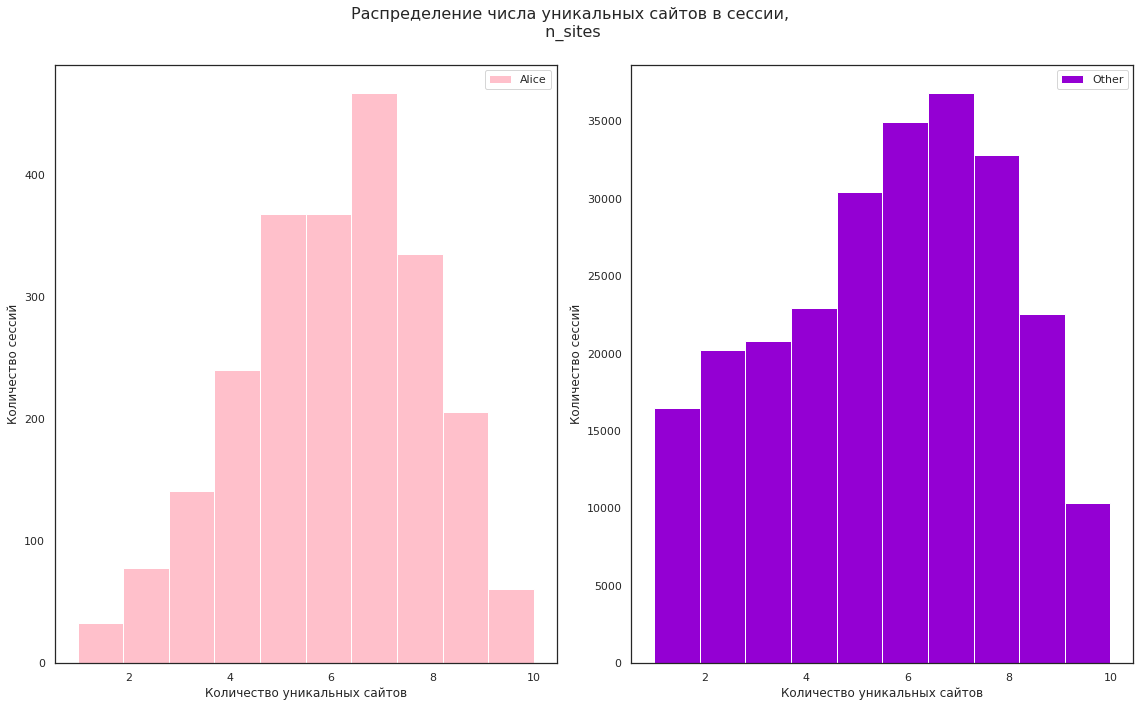

In [17]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.groupby('target')['n_sites']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('Распределение числа уникальных сайтов в сессии,\n n_sites', fontsize=16)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), label='{}'.format(key), color=color_dic[key])
    ax.legend()
    ax.set_xlabel('Количество уникальных сайтов')
    ax.set_ylabel('Количество сессий')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Видим что у Элис немного сессий из 1 - 2 сайтов

Теперь посмотрим на длительность сессий

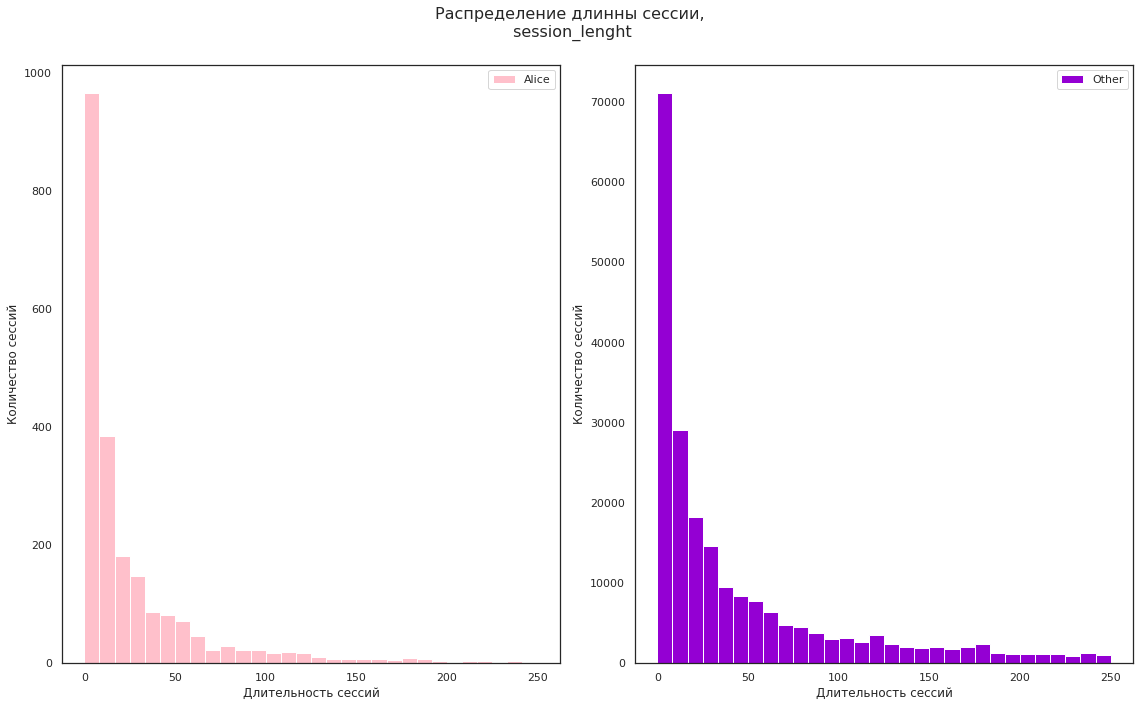

In [18]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.loc[X['session_lenght']<=250, ['session_lenght', 'target']].groupby('target')['session_lenght']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('Распределение длинны сессии,\n session_lenght', fontsize=16)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), label='{}'.format(key), color=color_dic[key], bins=30)
    ax.legend()
    ax.set_xlabel('Длительность сессий')
    ax.set_ylabel('Количество сессий')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Поведение Элис и остальных пользователей схожи

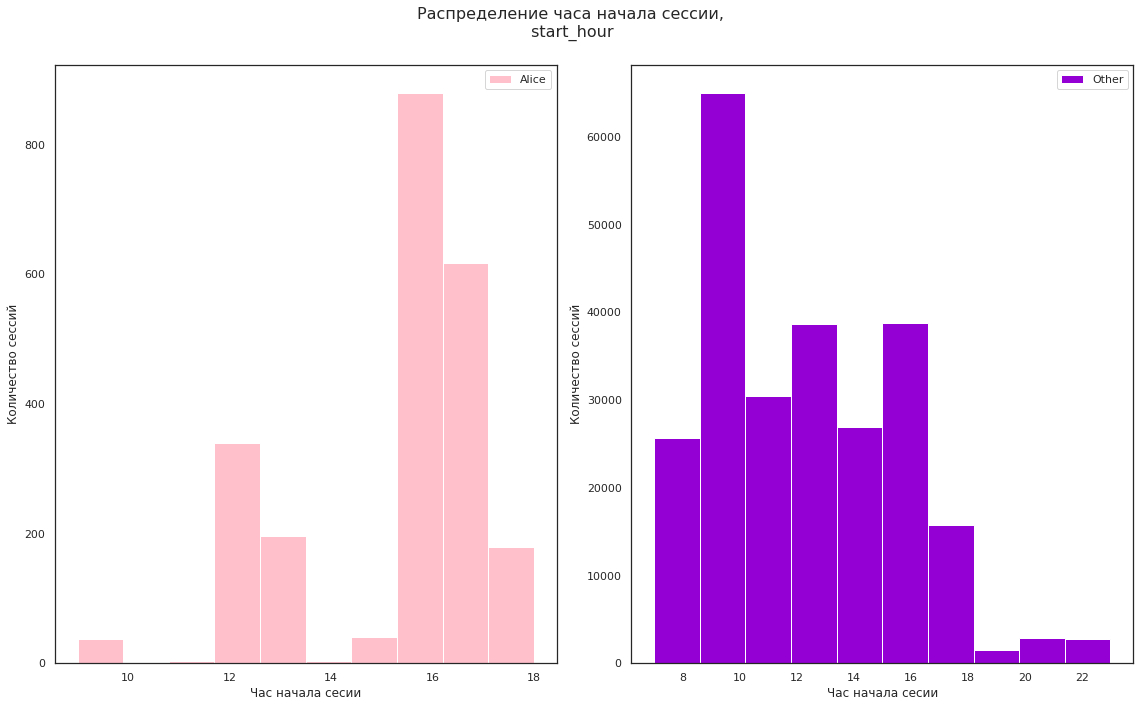

In [19]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.groupby('target')['start_hour']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('Распределение часа начала сессии,\n start_hour', fontsize=16)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), label='{}'.format(key), color=color_dic[key])
    ax.legend()
    ax.set_xlabel('Час начала сесии')
    ax.set_ylabel('Количество сессий')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Элис в вечерние часы не пользуется интернетом

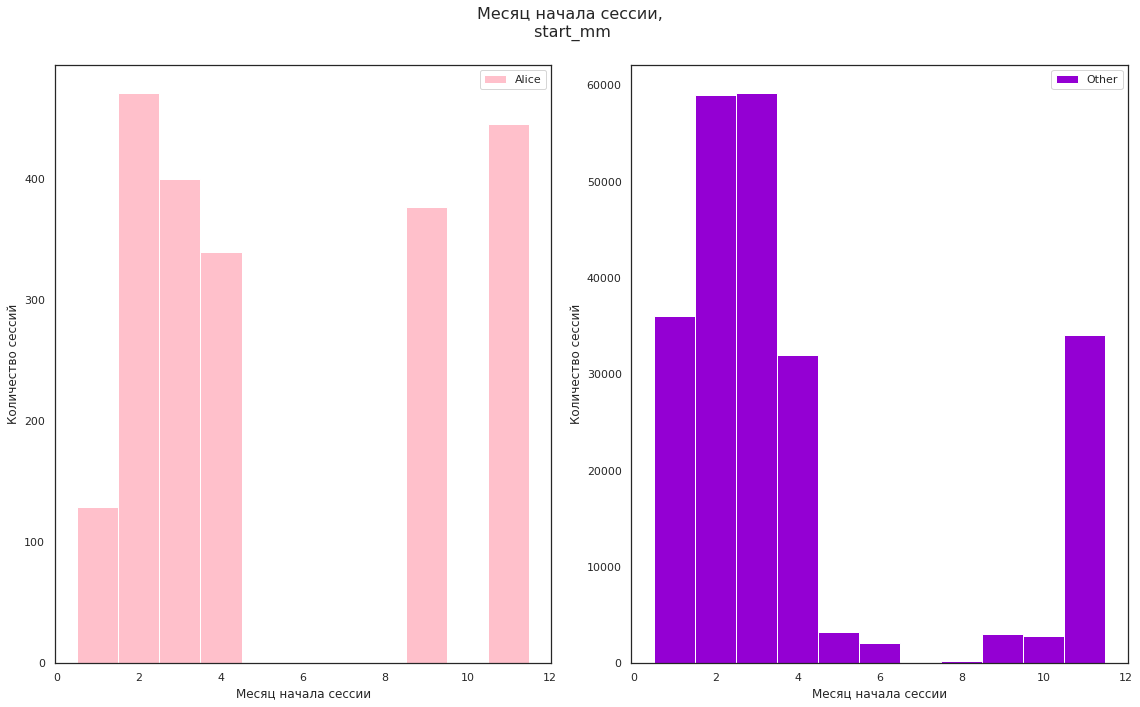

In [20]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.groupby('target')['start_mm']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('Месяц начала сессии,\n start_mm', fontsize=16)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), label='{}'.format(key), color=color_dic[key], bins=np.arange(1, 13) - 0.5)
    ax.legend()
    ax.set_xlabel('Месяц начала сессии')
    ax.set_ylabel('Количество сессий')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Элис не появлялась в сети с мая по сентябрь

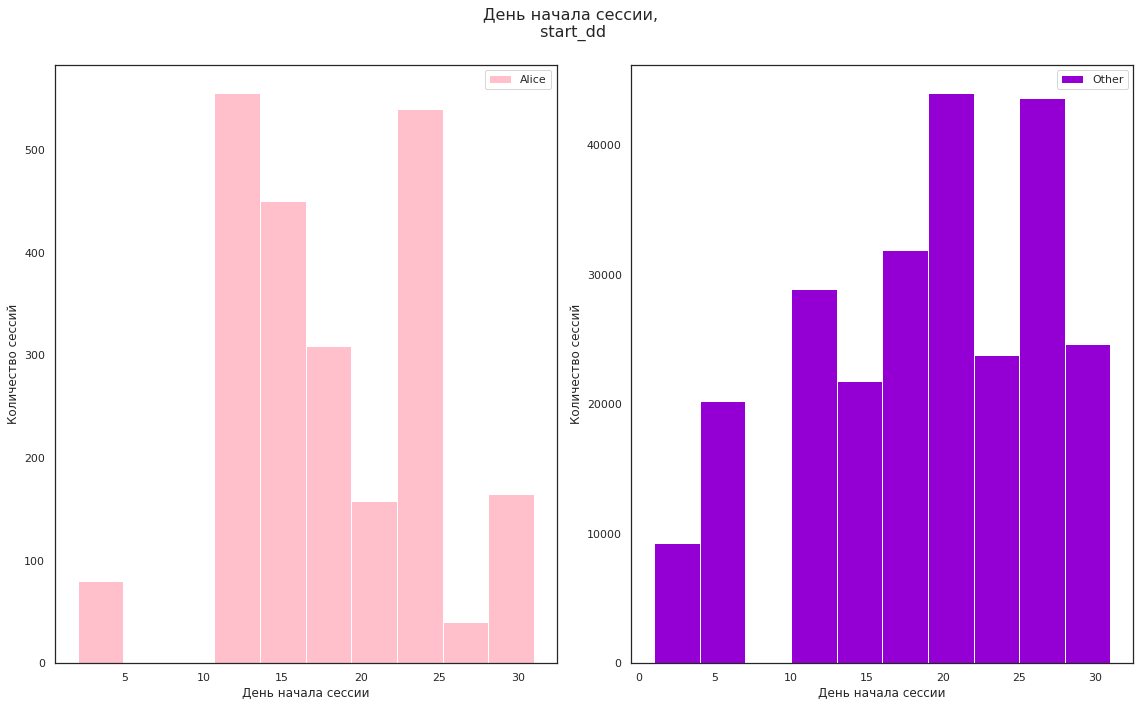

In [21]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.groupby('target')['start_dd']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('День начала сессии,\n start_dd', fontsize=16)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), label='{}'.format(key), color=color_dic[key])
    ax.legend()
    ax.set_xlabel('День начала сессии')
    ax.set_ylabel('Количество сессий')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Такая же картина с днём начала сессии, с 5-10 ее нет в сети

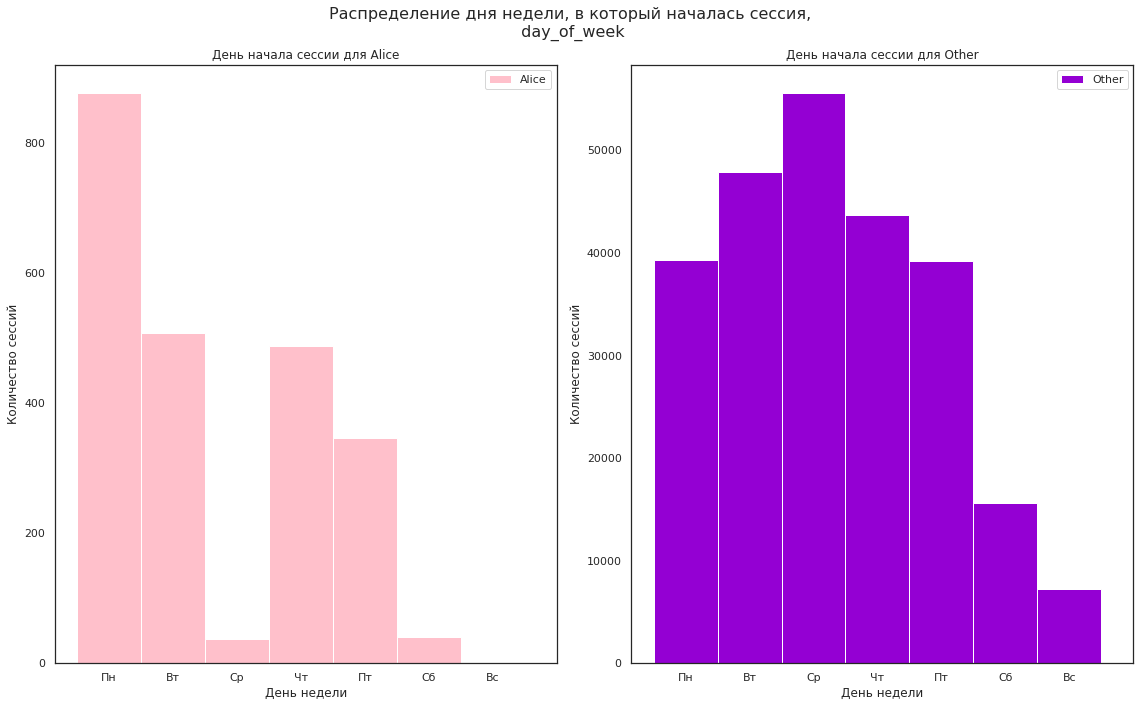

In [22]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
grouped = X.groupby('target')['day_of_week']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle('Распределение дня недели, в который началась сессия,\n day_of_week', fontsize=16)

plt.locator_params(numticks=7)

for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key), 
            label='{}'.format(key), 
            color=color_dic[key], 
            bins=np.arange(8) - 0.5)
    ax.set_xticks(range(8))
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.legend()
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('День недели')
    ax.set_title('День начала сессии для {}'.format(key))
    
fig.tight_layout()
fig.subplots_adjust(top=0.9);

Элис не заходит в интернет по воскресеньям

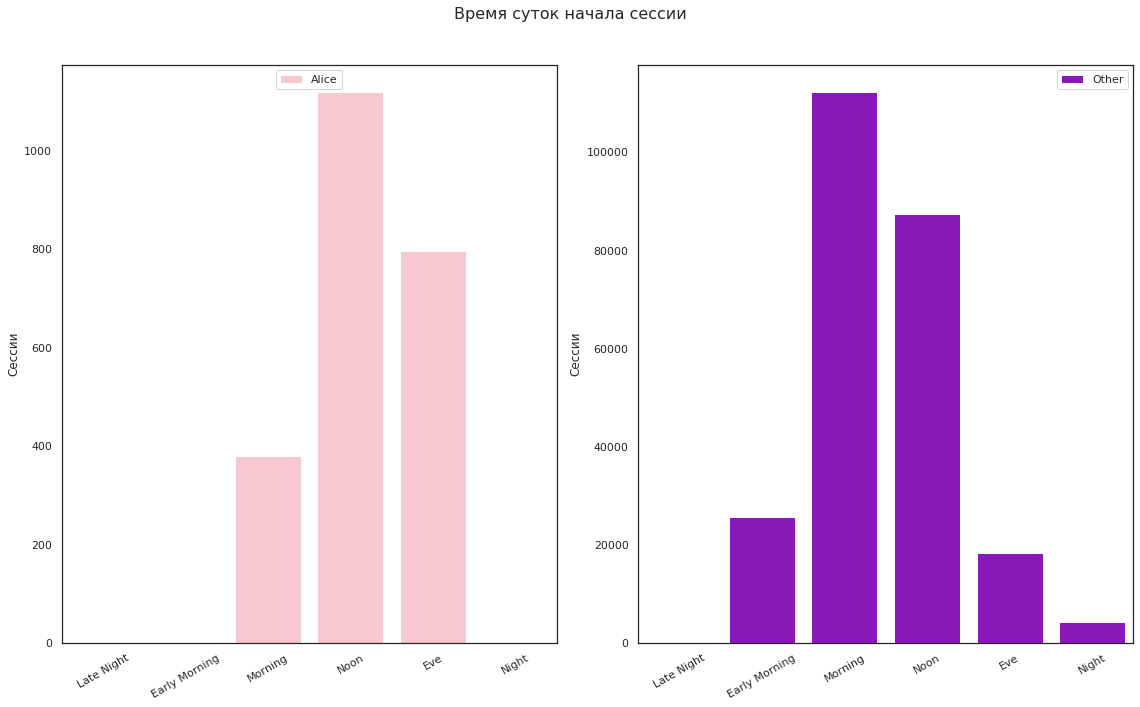

In [23]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharex=False)
grouped = X.groupby('target')['start_dt_part']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle("Время суток начала сессии", fontsize=16)

for i, (key, ax) in enumerate(targets):
    sns.countplot(grouped.get_group(key), label='{}'.format(key), color=color_dic[key], ax=ax)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Сессии')
    ax.tick_params(axis='x', rotation=30)


fig.tight_layout()
fig.subplots_adjust(top=0.9);

Раннее утро, ночь мы не видим сессии Элис

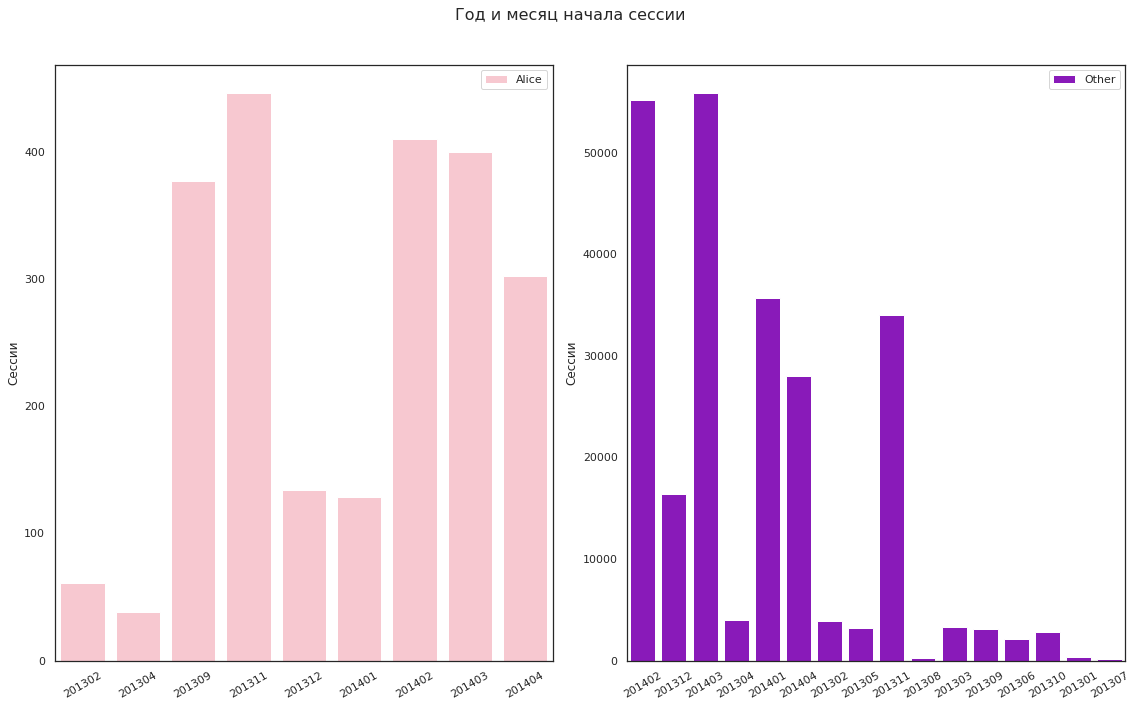

In [24]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharex=False)
grouped = X.groupby('target')['start_yyyymm']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle("Год и месяц начала сессии", fontsize=16)

for i, (key, ax) in enumerate(targets):
    sns.countplot(grouped.get_group(key), label='{}'.format(key), color=color_dic[key], ax=ax)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Сессии')
    ax.tick_params(axis='x', rotation=30)


fig.tight_layout()
fig.subplots_adjust(top=0.9);

В 2013 году Элис несколько месяцев подряд не появлялась в сети

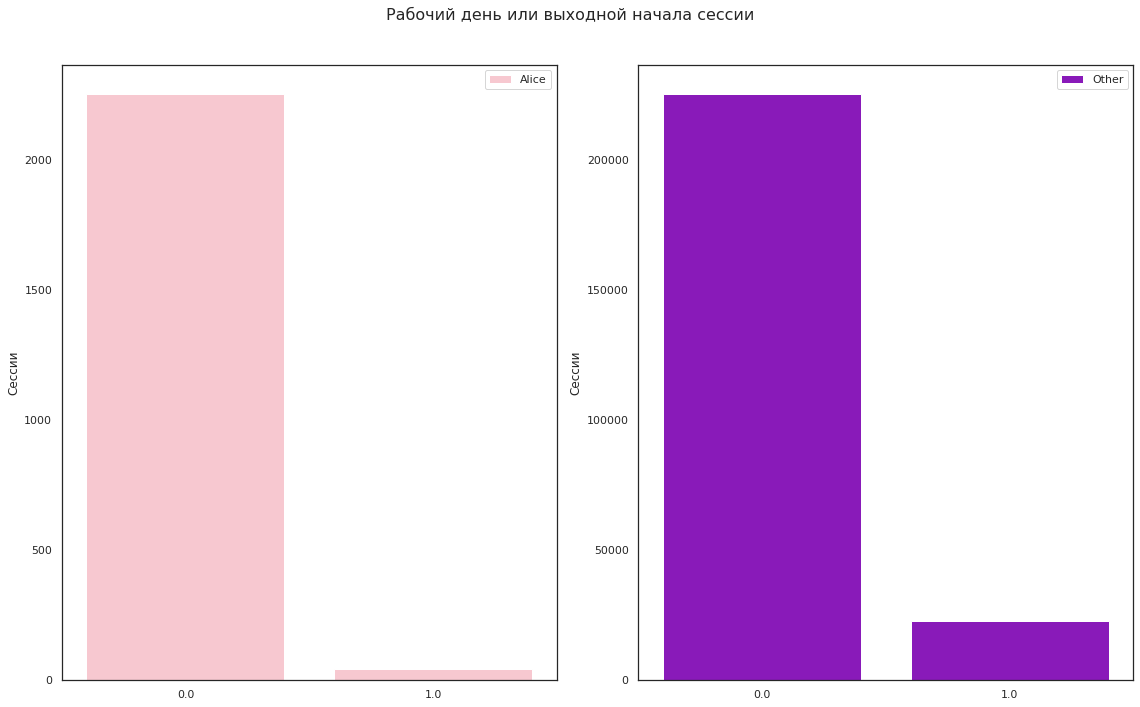

In [25]:
sns.set(color_codes=True, style='white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharex=False)
grouped = X.groupby('target')['holiday']

targets = zip(grouped.groups.keys(), axes.flatten())

fig.suptitle("Рабочий день или выходной начала сессии", fontsize=16)

for i, (key, ax) in enumerate(targets):
    sns.countplot(grouped.get_group(key), label='{}'.format(key), color=color_dic[key], ax=ax)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Сессии')

fig.tight_layout()
fig.subplots_adjust(top=0.9);

Предобработка данных
---

In [26]:
from sklearn.preprocessing import StandardScaler
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 82797
Data columns (total 31 columns):
site1             336358 non-null int64
site2             336358 non-null int64
site3             336358 non-null int64
site4             336358 non-null int64
site5             336358 non-null int64
site6             336358 non-null int64
site7             336358 non-null int64
site8             336358 non-null int64
site9             336358 non-null int64
site10            336358 non-null int64
session_lenght    336358 non-null float64
lenght            336358 non-null object
start_hour        336358 non-null int64
start_dt          336358 non-null object
start_yyyymm      336358 non-null object
start_mm          336358 non-null int64
start_dd          336358 non-null int64
start_yyyy        336358 non-null int64
start_dt_part     336358 non-null category
holiday           336358 non-null int64
day_of_week       336358 non-null int64
n_sites           336358 non-null int6

Будем использовать CountVectorizer

In [27]:
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [28]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_sites = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_sites = cv.transform(inp_test_file)
X_train_sites.shape, X_test_sites.shape

CPU times: user 14.8 s, sys: 228 ms, total: 15 s
Wall time: 14.5 s


((253561, 50000), (82797, 50000))

Переведем в категориальный тип необходимые колонки

In [29]:
cat_features = ['lenght', 'start_hour', 'start_dt', 'start_yyyymm', 'start_mm',
                'start_dd', 'start_yyyy', 'start_dt_part', 'day_of_week']
train_test_df[cat_features] = train_test_df[cat_features].astype('category')

Разделяю на несколько датафреймов (дф с сайтами, с новыми фичами и с временами переходов на другие сайты) для дальнейшей работы с ними

In [30]:
train_test_df_feat = train_test_df.loc[:, ~train_test_df.columns.isin(sites + diffs)]
train_test_df_diff = train_test_df[diffs]

Нормирую переменные

In [31]:
train_test_df_feat[['session_lenght', 'n_sites']] = \
                StandardScaler().fit_transform(train_test_df_feat[['session_lenght', 'n_sites']])

In [32]:
train_test_df_feat = pd.concat(
    [train_test_df_feat.drop(cat_features, axis=1),
     pd.get_dummies(train_test_df_feat[cat_features], drop_first=True)], axis=1)

In [33]:
train_test_df_diff = StandardScaler().fit_transform(train_test_df_diff)

In [35]:
from scipy.sparse import hstack
train_sparse = hstack([
    X_train_sites, 
    train_test_df_feat[:y.shape[0]], 
    train_test_df_diff[:y.shape[0]]
])

In [36]:
test_sparse = hstack([
    X_test_sites, 
    train_test_df_feat[y.shape[0]:], 
    train_test_df_diff[y.shape[0]:]
])

Кросс-валидация
---


In [37]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(train_sparse, y, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y)

In [39]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [67]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear', n_jobs=-1)

In [68]:
cv_logit = cross_val_score(logit, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
cv_logit, cv_logit.mean()

(array([ 0.99014097,  0.99321137,  0.99133383]), 0.99156205862615698)

In [69]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
auc_logit = roc_auc_score(y_valid, logit.predict(X_valid))
auc_logit

0.81525037535990841

In [71]:
%%time
Cs = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': Cs},
                                  scoring='roc_auc', n_jobs=-1, cv=skf, verbose=1)

logit_grid_searcher.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


CPU times: user 58.2 s, sys: 3.4 s, total: 1min 1s
Wall time: 2min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [72]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.99151185381002482, {'C': 1.6681005372000592})

In [74]:
logitCV = LogisticRegression(C=logit_grid_searcher.best_params_['C'], random_state=17, solver='liblinear', n_jobs=-1)
cv_logitCV = cross_val_score(logitCV, X_train, y_train, cv=skf, scoring='roc_auc')
cv_logitCV.mean()

0.99151185381002482

In [75]:
logitCV.fit(X_train, y_train)
auc_logitCV = roc_auc_score(y_valid, logitCV.predict(X_valid))
auc_logitCV

0.8202705036619492

In [76]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(logitCV.predict_proba(test_sparse)[:,1], 'answers/logit_with_feats4.csv') # CountVectorizer 0.94110

In [77]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [78]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = logitCV
n_train, val_train, val_test = learning_curve(estimator, 
                                              train_sparse, y, 
                                              train_sizes=train_sizes, 
                                              cv=skf,
                                              scoring='roc_auc',
                                              n_jobs=-1)

CPU times: user 809 ms, sys: 276 ms, total: 1.09 s
Wall time: 3min 9s


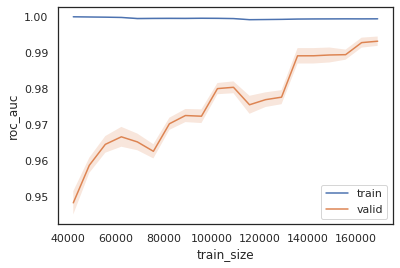

In [79]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='roc_auc')

Выводы:
---
Модель довольно неплохо идентифицирует пользователя, основываясь на его поведении в сети (посещение сайтов)

Как можно улучшить:
 - Попробовать различные сочетания кол-ва сайтов в сессии
 - Попробовать алгоритмы XGBoost, LightGBM

Как применять: 
* На основании схожести поведения в сети пользователей, можно строить рекомендации
* Определение нетипичных паттернов в поведении пользователей с целью идентификации фрода